[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
sharpe ratio of different strategies:
 risk_parity    [0.8813076434641617]
equal_wted     [0.5215456015625046]
dtype: object

sharpe ratio of strategies vs assets:
 risk_parity    [0.8813076434641617]
BND                        0.781256
GLD                        0.214938
VNQ                        0.218863
VTV                        0.359882
dtype: object


<Figure size 432x288 with 0 Axes>

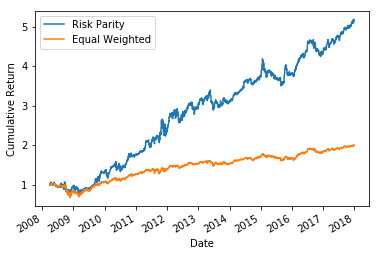

<Figure size 432x288 with 0 Axes>

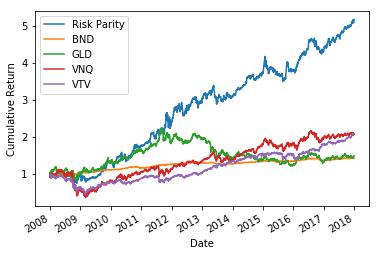

Text(0, 0.5, 'asset weights')

<Figure size 432x288 with 0 Axes>

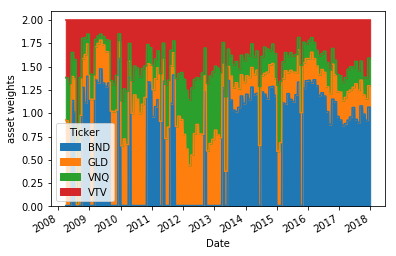

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import minimize

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override() 
import datetime 
from collections import OrderedDict
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")


def cov_ewma(ret_assets, lamda = 0.94):
    ret_mat = ret_assets.values
    T = len(ret_assets)
    coeff = np.zeros((T,1))
    S = ret_assets.cov()
    for i in range(1, T):
        S = lamda * S  + (1-lamda)* (ret_mat[i-1,:].reshape((-1,1)) @ ret_mat[i-1,:].reshape((1,-1)) )
        coeff[i] = (1-lamda)*lamda**(i)
    return S/np.sum(coeff)

   
# risk budgeting approach optimisation object function
def obj_fun(W, cov_assets, risk_budget):
    var_p = np.dot(W.transpose(), np.dot(cov_assets, W))
    sigma_p = np.sqrt(var_p)
    risk_contribution = W*np.dot(cov_assets, W)/sigma_p
    risk_contribution_percent = risk_contribution/sigma_p
    return np.sum((risk_contribution_percent-risk_budget)**2)
    #with many assets: use below function
    #risk_contribution_category = np.array([np.sum(risk_contribution[0:4]),np.sum(risk_contribution[4:7])])
    #return np.sum((risk_contribution_category-risk_budget)**2)
    

# calculate risk budgeting portfolio weight give risk budget
def riskparity_opt(ret_assets, risk_budget, lamda, method='ewma',Wts_min=0.0, leverage=False):
    num_assets = ret_assets.shape[1]
    if method=='ewma':
        cov_assets = cov_ewma(ret_assets, lamda)
    elif method=='ma':
        cov_assets = ret_assets.cov()
    else:
        cov_assets = cov_ewma(ret_assets, lamda)        
    
    w0 = 1.0 * np.ones((num_assets, 1)) / num_assets
    if leverage == True:
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-2. }, # Sum of weights = 200%
              {'type':'ineq', 'fun': lambda W: W-Wts_min}) # weights greater than min wts
    else:
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. }, # Sum of weights = 100%
              {'type':'ineq', 'fun': lambda W: W-Wts_min}) # weights greater than min wts
    return minimize(obj_fun, w0, args=(cov_assets, risk_budget), method='SLSQP', constraints=c_)


def getDataBatch(tickers, startdate, enddate):
    def getData(ticker):
        return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
    datas = map(getData, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))


def getReturns(tickers, start_dt, end_dt, freq='monthly'): 
    px_data = getDataBatch(tickers, start_dt, end_dt)
    # Isolate the `Adj Close` values and transform the DataFrame
    px = px_data[['Adj Close']].reset_index().pivot(index='Date', 
                           columns='Ticker', values='Adj Close')
    if (freq=='monthly'):
        px = px.resample('M').last()
        
    ret = px.pct_change().dropna()
    
    ret.columns = tickers
    return(ret)
    

if __name__ == "__main__":
    
    Flag_downloadData = True
    start_dt = datetime.datetime(2007, 12, 31)
    end_dt = datetime.datetime(2017, 12, 31)
    
    if Flag_downloadData:
        #Ticker: inflation protected bond etf:IPE(0.480041), TIP(0.518722) 
        #        gold etf: GLD(0.214938), IAU(0.220548)
        #        commodity etf: DBC(-0.301091)
        #        emerging market bond etf: EMB(0.585357) 
        #        emerging market equity etf: VWO(0.0445064)
        #        developed real estate etf: VNQ(0.218863)
        #        treasury etf: SHV(1.14855), SHY(0.969952), IEF(0.638735), TLT(0.426064), BND(0.781256)
        #        corporate bond etf: LQD(0.661977)
        #        u.s equity etf: VTV(0.359882), VUG(0.479576), IWM(0.346258), VIG, VO, VB
        Ticker_AllAsset = ['VTV','BND','VNQ','GLD']
        #with many assets: use below ticker
        #Ticker_AllAsset = ['LQD','SHV','SHY','TIP','EMB','VIG','VTV','VUG','VO','VB']
        stock_data = getDataBatch(Ticker_AllAsset, start_dt, end_dt)
        price_AllAsset = stock_data.reset_index().pivot(index='Date', columns='Ticker', values='Adj Close')
        
        writer = pd.ExcelWriter('RiskParityAssets.xlsx', engine='xlsxwriter')
        #with many assets: use below code
        #writer = pd.ExcelWriter('RiskParityAssets_M.xlsx', engine='xlsxwriter')
        price_AllAsset.to_excel(writer, sheet_name='Price',startrow=0, startcol=0, header=True, index=True)
    else:
        price_AllAsset = pd.read_excel('RiskParityAssets.xlsx', sheet_name='Price', header=0, index_col = 0)
        #with many assets: use below code
        #price_AllAsset = pd.read_excel('RiskParityAssets_M.xlsx', sheet_name='Price', header=0, index_col = 0)

ret_assets = price_AllAsset.pct_change().dropna()
ret_assets_demean = ret_assets - ret_assets.mean()
num_assets = ret_assets.shape[1]
    
lamda = 0.94
SS = cov_ewma(ret_assets_demean, lamda)
SS1 = cov_ewma(ret_assets, lamda)
datestr = ret_assets.index[ret_assets.index >= '2008-03-31']
mth_previous = datestr[0]
wts = pd.DataFrame(index=datestr, columns=ret_assets.columns)
ret_riskParity = pd.DataFrame(index=datestr, columns=['Risk Parity'])
window = 90
Wts_min = 0.01
risk_budget = 1.0/num_assets*np.ones([1,num_assets])
#with many assets: use below risk_budget
#assets_category=2
#risk_budget = 1.0/assets_category*np.ones([1,assets_category]) #risk-party
leverage = True
varmodel = 'ewma'
    
    
for t in datestr:
    if t.month==mth_previous:
        wts.loc[t] = wts.iloc[wts.index.get_loc(t)-1]
    else:
        mth_previous = t.month
            
        t_begin = t - timedelta(days=window)
        ret_used = ret_assets.loc[t_begin:t,:]
        wts.loc[t] = riskparity_opt(ret_used, risk_budget, lamda, varmodel, Wts_min, leverage).x
    ret_riskParity.loc[t] = np.sum(wts.loc[t] * ret_assets.loc[t])
        
wts[wts<0]=0.0

ret_equalwted = pd.DataFrame(np.sum(1.0*ret_assets[ret_assets.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])

    
#%%
# get covariance matrix
assets_cov_matrix=ret_assets.cov()
    
ret_cumu_assets = (ret_assets + 1).cumprod()
ret_cumu_riskP = (ret_riskParity + 1).cumprod()
ret_cumu_equalwt = (ret_equalwted + 1).cumprod()
    
ret_annual_assets = ret_cumu_assets.iloc[-1]**(250/len(ret_cumu_assets))-1
std_annual_assets = ret_assets.std()*np.sqrt(250)
sharpe_ratio_assets = ret_annual_assets/std_annual_assets
    
ret_annual_riskP = ret_cumu_riskP.iloc[-1]**(250/len(ret_cumu_riskP))-1
std_annual_riskP = ret_riskParity.std()*np.sqrt(250)
sharpe_ratio_riskP = ret_annual_riskP/std_annual_riskP
    
ret_annual_equalwt = ret_cumu_equalwt.iloc[-1]**(250/len(ret_cumu_equalwt))-1
std_annual_equalwt = ret_equalwted.std()*np.sqrt(250)
sharpe_ratio_equalwt = ret_annual_equalwt/std_annual_equalwt
    
#sharpe_table = [sharpe_ratio_riskP, sharpe_ratio_equalwt]
sharpe_table = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                     ('equal_wted', sharpe_ratio_equalwt.values),
                     )))
sharpe_table1 = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                     ('BND', sharpe_ratio_assets['BND']),
                     ('GLD', sharpe_ratio_assets['GLD']),
                     ('VNQ', sharpe_ratio_assets['VNQ']),
                     #('LQD', sharpe_ratio_assets['LQD']),
                     #('SHV', sharpe_ratio_assets['SHV']),
                     #('SHY', sharpe_ratio_assets['SHY']),
                     #('TIP', sharpe_ratio_assets['TIP']),
                     #('EMB', sharpe_ratio_assets['EMB']),
                     #('VIG', sharpe_ratio_assets['VIG']),
                     ('VTV', sharpe_ratio_assets['VTV']),
                     #('VUG', sharpe_ratio_assets['VUG']),
                     #('VO', sharpe_ratio_assets['VO']),
                     #('VB', sharpe_ratio_assets['VB'])
                     )))
print('sharpe ratio of different strategies:\n',sharpe_table)
print('\nsharpe ratio of strategies vs assets:\n',sharpe_table1)


figure_count = 1
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_equalwt], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.show()
    
# compare the portfolio cumulative returns vs. asset returns
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_assets], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.show()
    
# plot the historical weights of the assets
# area plot showing the weights
plt.figure(figure_count)
figure_count = figure_count + 1
wts.plot.area()
plt.ylabel('asset weights')

At the date " 2017-12-29 00:00:00 " the next period HiVol flag is True
For volatility flag is: True
Ticker       BND       GLD       VNQ       VTV
Ticker                                        
BND     1.000000  0.182781 -0.143732 -0.180910
GLD     0.182781  1.000000  0.017544  0.004453
VNQ    -0.143732  0.017544  1.000000  0.812518
VTV    -0.180910  0.004453  0.812518  1.000000
sharpe ratio of different strategies:
 risk_parity    [0.8146421134529727]
equal_wted     [0.5215456015625046]
dtype: object

sharpe ratio of strategies vs assets:
 risk_parity    [0.8146421134529727]
VTV                        0.359882
BND                        0.781256
VNQ                        0.218863
GLD                        0.214938
dtype: object


<Figure size 432x288 with 0 Axes>

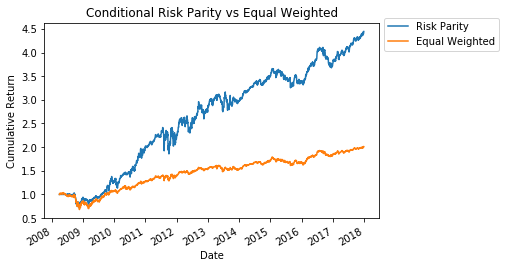

<Figure size 432x288 with 0 Axes>

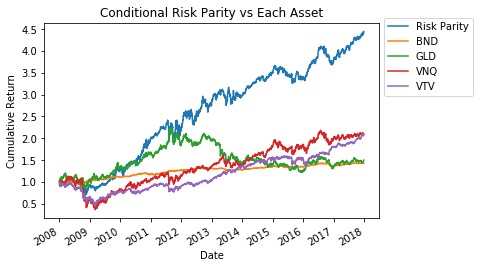

Text(0, 0.5, 'asset weights')

<Figure size 432x288 with 0 Axes>

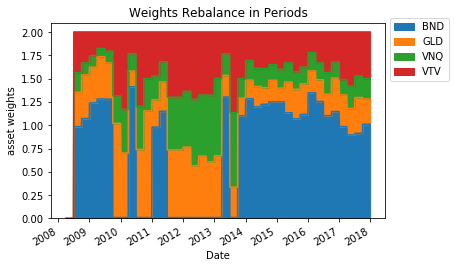

In [12]:
# Returns
price_VTV = price_AllAsset['VTV']
price_BND = price_AllAsset['BND']
price_VNQ = price_AllAsset['VNQ']
price_GLD = price_AllAsset['GLD']


# merging/joining dataframe
frames = [price_VTV, price_BND,price_VNQ,price_GLD]# this creats a list of two frames

ret_VTV = price_VTV.pct_change().dropna().to_frame('Return')
ret_BND = price_BND.pct_change().dropna().to_frame('Return')
ret_VNQ = price_VNQ.pct_change().dropna().to_frame('Return')
ret_GLD = price_GLD.pct_change().dropna().to_frame('Return')

# demean the return
ret_VTV_mean = np.mean(ret_VTV)
ret_VTV = ret_VTV - ret_VTV_mean
ret_BND_mean = np.mean(ret_BND)
ret_BND = ret_BND - ret_BND_mean
ret_VNQ_mean = np.mean(ret_VNQ)
ret_VNQ = ret_VNQ - ret_VNQ_mean
ret_GLD_mean = np.mean(ret_GLD)
ret_GLD = ret_GLD - ret_GLD_mean

#%%
# Set up backtest
T = len(ret_VTV) 
p = 0.05
value = 1
VaR = np.full([T,2],np.nan)
lamda = 0.94
s11 = ret_VTV[:window].var() # initial guess of covariance

# calc EWMA cov till t=window
for t in range(1,window):
    s11 = lamda * s11  + (1-lamda) * ret_VTV.iloc[t-1]**2

# Listing 8.6 : Running backtest 
VaR = np.full([T,2],np.nan)
for t in range(window,T):
    t1 = t-window # only use data in the window, will leads to more volatile VaR
    #t1 = 0 # use all data available, instead of those in the window
    t2 = t
    ret_inWindow = ret_VTV[t1:t2]
    s11 = lamda * s11  + (1-lamda) * ret_VTV.iloc[t-1]**2
    # 1 - VaR based on EWMA method
    VaR[t,0] = -stats.norm.ppf(p,0,1) * np.sqrt(s11)*value
    # 2 - VaR based on simple MA method
    VaR[t,1] = -ret_inWindow.std()*stats.norm.ppf(p,0,1)*value
    
label_m = ['EWMA','MA']

VaR = pd.DataFrame(data=VaR, index=ret_VTV.index, columns=label_m)
VaR = VaR.dropna()
#%%
#
# create risk regimes: high vol. and low vol. regimes
#
# define high vol. regimes as when EWMA VaR are higher than MA VaR
flag_HiVol = VaR['EWMA']>VaR['MA']
# merge return data with flag of vol regimes
# merging/joining dataframe
frames = [flag_HiVol, ret_assets]# this creats a list of two frames
# merge the two frames by simply combing them
ret_allwFlag = pd.concat(frames, axis=1, join='inner') # merge only the common rows
ret_allwFlag.columns = ['HiVolFlag','VTV', 'BND', 'VNQ', 'GLD']
# Calculate conditional expected return and risk
ret_all_HiVol = ret_allwFlag[ret_allwFlag['HiVolFlag']]
ret_all_LowVol = ret_allwFlag[~ret_allwFlag['HiVolFlag']]
# Calculate mean, covarinace and correlation
mean_ret_HiVol = ret_all_HiVol[['VTV', 'BND', 'VNQ', 'GLD']].mean()
cov_ret_HiVol = ret_all_HiVol[['VTV', 'BND', 'VNQ', 'GLD']].cov()
mean_ret_LowVol = ret_all_LowVol[['VTV', 'BND', 'VNQ', 'GLD']].mean()
cov_ret_LowVol = ret_all_LowVol[['VTV', 'BND', 'VNQ', 'GLD']].cov()
# next period flag actuall is the last row of the flag_HiVol series
print('At the date " {0} " the next period HiVol flag is {1}'.format(flag_HiVol.index[-1], flag_HiVol[-1]))
print('For volatility flag is:',flag_HiVol[-1])
    
num_risk=4
risk_budget1 = 1.0/num_risk*np.ones([1,num_risk]) #risk-party
    
for t in datestr:
    # construct risk budgeting portfolio and re-balance on monthly basis
    if t.quarter==mth_previous:
        #t.month==mth_previous:
        #t.year==mth_previous:
        # keep the same portfolio weights within the month
        wts.loc[t] = wts.iloc[wts.index.get_loc(t)-1]
    else:
        # update the value of the previous month 
        mth_previous = t.quarter
        #mth_previous = t.month
        # mth_previous = t.year
            
        #risk-on
        ret_used = ret_all_HiVol.loc['2008-05-13':t,:]
        ret_used = ret_all_HiVol.loc['2008-05-13':t,:].iloc[:,1:5]
        a=riskparity_opt(ret_used, risk_budget1, lamda, varmodel, Wts_min, leverage).x
        wts.loc[t] = a
        #risk-off
        ret_used1= ret_all_LowVol.loc['2008-05-12':t,:]
        ret_used1= ret_all_LowVol.loc['2008-05-12':t,:].iloc[:,1:5]
        b=riskparity_opt(ret_used1, risk_budget1, lamda, varmodel, Wts_min, leverage).x
        wts.loc[t] = b
            
    # calculate risk budgeting portfolio returns
    ret_riskParity.loc[t] = np.sum(wts.loc[t] * ret_assets.loc[t])
        
# Due to precision issue, wts could be a tiny negative number instead of zero, make them zero
wts[wts<0]=0.0
# Construct equal weighted portfolio
ret_equalwted = pd.DataFrame(np.sum(1.0*ret_assets[ret_assets.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])
# Construct 60/40 weighted portfolio
#ret_equalwted = pd.DataFrame(np.sum(1.0*ret_assets[ret_assets.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])
        
#%%
#Correlstion
corr=ret_assets.corr()
print(corr)
dfconditional=pd.DataFrame(corr)       
writer = pd.ExcelWriter('Correlation.xlsx', engine='xlsxwriter')
corr.to_excel(writer, sheet_name='Correlation',startrow=0, startcol=0, header=True, index=True)
       
    
# Calculate performance stats
ret_cumu_assets = (ret_assets + 1).cumprod()
ret_cumu_riskP = (ret_riskParity + 1).cumprod()
ret_cumu_equalwt = (ret_equalwted + 1).cumprod()
    
ret_annual_assets = ret_cumu_assets.iloc[-1]**(250/len(ret_cumu_assets))-1
std_annual_assets = ret_assets.std()*np.sqrt(250)
sharpe_ratio_assets = ret_annual_assets/std_annual_assets
    
ret_annual_riskP = ret_cumu_riskP.iloc[-1]**(250/len(ret_cumu_riskP))-1
std_annual_riskP = ret_riskParity.std()*np.sqrt(250)
sharpe_ratio_riskP = ret_annual_riskP/std_annual_riskP
    
ret_annual_equalwt = ret_cumu_equalwt.iloc[-1]**(250/len(ret_cumu_equalwt))-1
std_annual_equalwt = ret_equalwted.std()*np.sqrt(250)
sharpe_ratio_equalwt = ret_annual_equalwt/std_annual_equalwt
    
#sharpe_table = [sharpe_ratio_riskP, sharpe_ratio_equalwt]
sharpe_table = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                     ('equal_wted', sharpe_ratio_equalwt.values),
                     )))
sharpe_table1 = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                     ('VTV', sharpe_ratio_assets['VTV']),
                     ('BND', sharpe_ratio_assets['BND']),
                     ('VNQ', sharpe_ratio_assets['VNQ']),
                     ('GLD', sharpe_ratio_assets['GLD']),
                     )))
sharpe_table2 = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                     ('equal_weighted',sharpe_ratio_equalwt.values),
                     ('VTV', sharpe_ratio_assets['VTV']),
                     ('BND', sharpe_ratio_assets['BND']),
                     ('VNQ', sharpe_ratio_assets['VNQ']),
                     ('GLD', sharpe_ratio_assets['GLD']),
                     )))
dfsr = pd.DataFrame(sharpe_table2,columns=['Sharpe Ratio'])
print('sharpe ratio of different strategies:\n',sharpe_table)
print('\nsharpe ratio of strategies vs assets:\n',sharpe_table1)
#%%
# compare the portfolio cumulative returns
figure_count = 1
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_equalwt,], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.legend(loc='UpperRight', bbox_to_anchor=(1,1.05))
plt.title('Conditional Risk Parity vs Equal Weighted')
plt.show()
    
# compare the portfolio cumulative returns vs. asset returns
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_assets], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.legend(loc='UpperRight', bbox_to_anchor=(1,1.05))
plt.title('Conditional Risk Parity vs Each Asset')
plt.show()
    
# plot the historical weights of the assets
# area plot showing the weights
plt.figure(figure_count)
figure_count = figure_count + 1
wts.plot.area()
plt.legend(loc='UpperRight', bbox_to_anchor=(1,1.05))
plt.title('Weights Rebalance in Periods')
plt.ylabel('asset weights')